In [2]:
%load_ext autoreload
%autoreload 2

# Plot TDA vs Mix Venn Diagram as 1% FDR

In [130]:
from extract_search_result import *
from load_search_result import * 
from mixture_model import MixtureModel
from mixture_model_base import MixtureModelBase
from myutils import *
from xlms import XLMS_Dataset
register_info_dir('../results/info/')

In [86]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle

## Load TDA result

In [9]:
df = load_decoy_res('alban')
df

,score_type,higher_score_better,significance_threshold,MZ,RT,spectrum_reference,xl_chain,xl_pos1,spectrum_index,xl_type,xl_rank,xl_term_spec_alpha,xl_term_spec_beta,isotope_error,score,sequence,charge,aa_before,aa_after,start,end,protein_refs,fragment_annotation,xl_mod,xl_mass,xl_pos2,precursor_mz_error_ppm,OpenPepXL:score,OpenPepXL:xquest_score,OpenPepXL:xcorr xlink,OpenPepXL:xcorr common,OpenPepXL:match-odds,OpenPepXL:intsum,OpenPepXL:intsum_alpha,OpenPepXL:intsum_beta,OpenPepXL:total_current,OpenPepXL:wTIC,OpenPepXL:TIC,OpenPepXL:prescore,OpenPepXL:log_occupancy,OpenPepXL:log_occupancy_alpha,OpenPepXL:log_occupancy_beta,matched_xlink_alpha,matched_xlink_beta,matched_linear_alpha,matched_linear_beta,ppm_error_abs_sum_linear_alpha,ppm_error_abs_sum_linear_beta,ppm_error_abs_sum_xlinks_alpha,ppm_error_abs_sum_xlinks_beta,ppm_error_abs_sum_linear,ppm_error_abs_sum_xlinks,ppm_error_abs_sum_alpha,ppm_error_abs_sum_beta,ppm_error_abs_sum,precursor_total_intensity,precursor_target_intensity,precursor_signal_proportion,precursor_target_peak_count,precursor_residual_peak_count,selected,sequence_beta,target_decoy,protein_references,xl_pos1_protein,xl_pos2_protein,accessions_beta,xl_target_decoy_alpha,xl_target_decoy_beta,delta_score
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,OpenPepXL:score,true,0.0,403.549285888671989,1531.754510525999876,file=20210702_L1_UM5_alban001_SA_EXT00_Ilse_fb...,MS:1002509,0,5146,mono-link,1,ANYWHERE,ANYWHERE,0,0.206916506420356,K(Xlink:DSS[155])M(Oxidation)LEEIM(Oxidation)K,3,R,Y,113,120,PH_1,"130.08673095703125,0.113271534442902,1,""[alpha...",,155.094628715,-,5.623047652362637,0.206917,14.799329816441892,0.035714285714286,0.06,6.540670379111752,0.254607543349266,0.254607543349266,0.0,28.876633374020457,0.008817078502590602,0.008817078502590602,0.0,6.261729721704407,6.261729721704407,0.0,0,0,2,0,3.808223485946655,0.0,0.0,0.0,3.808223485946655,0.0,3.808223485946655,0.0,3.808223485946655,38078474.0,38078474.0,1.0,2,0,false,-,target,unique,114,-,-,target,-,0.0
1,OpenPepXL:score,true,0.0,676.317626953125,1532.620606190999979,file=20210702_L1_UM5_alban001_SA_EXT00_Ilse_fb...,MS:1002509,13,5147,mono-link,1,ANYWHERE,ANYWHERE,4,0.29639178691169,GAGIC(Carbamidomethyl)TC(Carbamidomethyl)DWIMS...,3,R,E,2348,2363,PH_23,"175.11944580078125,8.527279831469059e-03,1,""[a...",,156.07864431,-,8.269221206834457,0.296392,35.44476371123733,0.040322580645161,0.1375,15.215917882642449,0.99181649228558,0.99181649228558,0.0,6.493932828539982,0.152729712251823,0.152729712251823,0.0,21.97885628770352,21.97885628770352,0.0,2,0,8,0,10.119914323091507,0.0,11.805193662643433,0.0,10.119914323091507,11.805193662643433,10.456970191001892,0.0,10.456970191001892,168930797.0,155311152.0,0.919377370841387,3,1,false,-,decoy,unique,2362,-,-,decoy,-,0.0
2,OpenPepXL:score,true,0.0,676.317626953125,1532.620606190999979,file=20210702_L1_UM5_alban001_SA_EXT00_Ilse_fb...,MS:1002509,4,5147,mono-link,2,ANYWHERE,ANYWHERE,1,0.132929575704809,KQC(Carbamidomethyl)SK(Xlink:DSS[155])EDGGGWWYNR,3,R,C,421,435,PH_0,"129.102584838867188,6.403847131878138e-03,1,""[...",,155.094628715,-,5.626624486793357,0.132930,11.631505230501773,0.025423728813559,0.122222222222222,4.520585538735252,0.019674118608236,0.019674118608236,0.0,6.493932828539982,0.003029615354469197,0.003029615354469197,0.0,6.448344497504777,6.448344497504777,0.0,0,0,3,0,3.962241729100545,0.0,0.0,0.0,3.962241729100545,0.0,3.962241729100545,0.0,3.962241729100545,168930797.0,155311152.0,0.919377370841387,3,1,false,-,target,unique,426,-,-,target,-,0.0
3,OpenPepXL:score,true,0.0,676.317626953125,1532.620606190999979,file=20210702_L1_UM5_alban001_SA_EXT00_Ilse_fb...,MS:1002509,0,5147,mono-link,3,ANYWHERE,ANYWHERE,1,0.036512947727189,K(Xlink:DSS[155])QC(Carbamidomethyl)SKEDGGGWWYNR,3,R,C,421,435,PH_0,"175.11944580078125,8.527279831469059e-03,1,""[a...",,155.094628715,-,5.626624486793357,0.036513,7.202805740064727,0.044642857142857,0.072916666666667,2.791442188809202,0.0132702714

In [ ]:
info = json.load(open('../results/info/alban.json'))

In [61]:
pd.options.mode.copy_on_write = True

In [85]:
def get_TDA_pep(df, info, fdr_thres=0.01):
    top_match = df.query('xl_rank == 1')
    
    s1 = top_match['OpenPepXL:score'].to_numpy() * 300
    
    fdr = np.interp(s1, (info['scores'][::-1]), (info['curve_fdr'][::-1]))
    
    top_match['fdr'] = fdr

    peps = top_match.query(f'fdr < {fdr_thres} and target_decoy == "target"')[['sequence', 'sequence_beta']]
    return set(peps.itertuples(index=False, name=None))

len(get_TDA_pep(df, info))


41

## Load Mix result

In [121]:
models = pickle.load(open('../figures_python_diffsign_2S2_unweighted_pdf_mode_gaussian_initskew_1_2_5/alban/models.pickle', 'rb'))

In [122]:
models = np.array(models)

In [123]:
dataset = XLMS_Dataset('alban')

{'mat': array([[ 62.07495193,  39.87887271, 199.56628959, ...,  79.5411614 ,
         56.71604082, 206.04280217],
       [  0.        ,  10.95388432, 190.35919864, ...,  72.006759  ,
         55.68524239, 189.2629568 ]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'curve_dd', 'curve_matches'])


In [125]:
best = reduce(max_ll, models, (0,))
frozen_model = best[()]['model']

dummy_skew = {k: 1 for k in ['C', 'IC', 'IC2', 'I1', 'I2', 'NA']}
model = MixtureModel(dummy_skew, ic2_comp=True)
model.from_frozen(frozen_model, dataset.mat.T)
model

<Figure size 1600x900 with 0 Axes>

failed to plot fdr


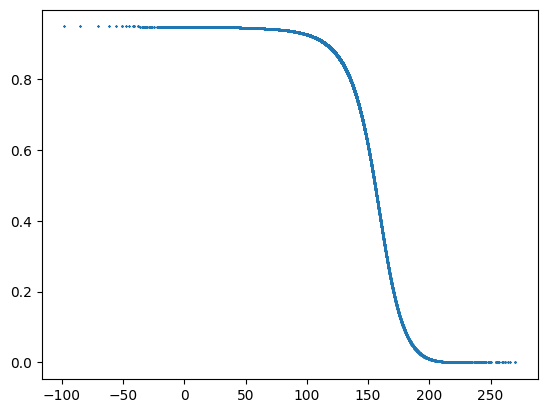

In [127]:
fdr = model.fdr(s1)
plt.scatter(s1, fdr, s=1, marker='+')

In [131]:
df = load_res('alban')
df

,score_type,higher_score_better,significance_threshold,MZ,RT,spectrum_reference,xl_chain,xl_pos1,spectrum_index,xl_type,xl_rank,xl_term_spec_alpha,xl_term_spec_beta,isotope_error,score,sequence,charge,start,end,fragment_annotation,xl_mod,xl_mass,xl_pos2,precursor_mz_error_ppm,OpenPepXL:score,OpenPepXL:xquest_score,OpenPepXL:xcorr xlink,OpenPepXL:xcorr common,OpenPepXL:match-odds,OpenPepXL:intsum,OpenPepXL:intsum_alpha,OpenPepXL:intsum_beta,OpenPepXL:total_current,OpenPepXL:wTIC,OpenPepXL:TIC,OpenPepXL:prescore,OpenPepXL:log_occupancy,OpenPepXL:log_occupancy_alpha,OpenPepXL:log_occupancy_beta,matched_xlink_alpha,matched_xlink_beta,matched_linear_alpha,matched_linear_beta,ppm_error_abs_sum_linear_alpha,ppm_error_abs_sum_linear_beta,ppm_error_abs_sum_xlinks_alpha,ppm_error_abs_sum_xlinks_beta,ppm_error_abs_sum_linear,ppm_error_abs_sum_xlinks,ppm_error_abs_sum_alpha,ppm_error_abs_sum_beta,ppm_error_abs_sum,precursor_total_intensity,precursor_target_intensity,precursor_signal_proportion,precursor_target_peak_count,precursor_residual_peak_count,selected,sequence_beta,target_decoy,protein_references,xl_pos1_protein,xl_pos2_protein,accessions_beta,xl_target_decoy_alpha,xl_target_decoy_beta,delta_score,accession,is decoy,aa_before,aa_after
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
18703,OpenPepXL:score,True,0.0,403.549285888672,1531.7545105259999,file=20210702_L1_UM5_alban001_SA_EXT00_Ilse_fb...,MS:1002509,0,5146,mono-link,1,ANYWHERE,ANYWHERE,0,0.0,['K(Xlink:DSS[155])M(Oxidation)LEEIM(Oxidation...,3,[113],[120],"130.08673095703125,0.113271534442902,1,""[alpha...",,155.094628715,-,5.623047652362637,0.206917,14.799329816441892,0.035714285714286,0.06,6.540670379111752,0.254607543349266,0.254607543349266,0.0,28.876633374020457,0.008817078502590602,0.008817078502590602,0.0,6.261729721704407,6.261729721704407,0.0,0,0,2,0,3.808223485946655,0.0,0.0,0.0,3.808223485946655,0.0,3.808223485946655,0.0,3.808223485946655,38078474.0,38078474.0,1.0,2,0,false,-,target,unique,114,-,-,target,-,0.0,['sp|P02679|FIBG_HUMAN'],False,['R'],['Y']
18704,OpenPepXL:score,True,0.0,676.317626953125,1532.620606191,file=20210702_L1_UM5_alban001_SA_EXT00_Ilse_fb...,MS:1002509,4,5147,mono-link,1,ANYWHERE,ANYWHERE,1,0.0,['KQC(Carbamidomethyl)SK(Xlink:DSS[155])EDGGGW...,3,[421],[435],"129.102584838867188,6.403847131878138e-03,1,""[...",,155.094628715,-,5.626624486793357,0.132930,11.631505230501773,0.025423728813559,0.122222222222222,4.520585538735252,0.019674118608236,0.019674118608236,0.0,6.493932828539982,0.003029615354469197,0.003029615354469197,0.0,6.448344497504777,6.448344497504777,0.0,0,0,3,0,3.962241729100545,0.0,0.0,0.0,3.962241729100545,0.0,3.962241729100545,0.0,3.962241729100545,168930797.0,155311152.0,0.919377370841387,3,1,false,-,target,unique,426,-,-,target,-,0.0,['sp|P02675|FIBB_HUMAN'],False,['R'],['C']
18705,OpenPepXL:score,True,0.0,676.317626953125,1532.620606191,file=20210702_L1_UM5_alban001_SA_EXT00_Ilse_fb...,MS:1002509,0,5147,mono-link,2,ANYWHERE,ANYWHERE,1,0.0,['K(Xlink:DSS[155])QC(Carbamidomethyl)SKEDGGGW...,3,[421],[435],"175.11944580078125,8.527279831469059e-03,1,""[a...",,155.094628715,-,5.626624486793357,0.036513,7.202805740064727,0.044642857142857,0.072916666666667,2.791442188809202,0.013270271476358,0.013270271476358,0.0,6.493932828539982,0.002043487640961895,0.002043487640961895,0.0,4.482641825743522,4.482641825743522,0.0,0,0,2,0,4.607253670692444,0.0,0.0,0.0,4.607253670692444,0.0,4.607253670692444,0.0,4.607253670692444,168930797.0,155311152.0,0.919377370841387,3,1,false,-,target,unique,422,-,-,target,-,0.0,['sp|P02675|FIBB_HUMAN'],False,['R'],['C']
18706,OpenPepXL:score,True,0.0,753.4262,1532.841307263,file=20210702_L1_UM5_alban001_SA_EXT00_Ilse_fb...,MS:1002510,4,5148,cross-link,1,ANYWHERE,ANYWHERE,1,0.0,['C(Carbamidomethyl)QKGFVLR'],3,[266],[273],"130.086639404296875,0.051163587719202,1,""[alph...",DSS,138.0680796,2,0.406142227208749,0.665221,66.7806826594,0.073529411764706,0.19811320754717,29.577861442119623,1

In [133]:
def get_Mix2s_peps(df, model, fdr_thres=0.01):
    top_match = df.query('xl_rank == 1')
    
    s1 = top_match['OpenPepXL:score'].to_numpy() * 300
    
    fdr = model.fdr(s1)
    
    top_match['fdr'] = fdr

    peps = top_match.query(f'fdr < {fdr_thres} and target_decoy == "target"')[['sequence', 'sequence_beta']]
    return set(peps.itertuples(index=False, name=None))

len(get_Mix2s_peps(df, model))

195

## Calc 1% FDR